In [41]:
import numpy as np
import pandas as pd
import ccxt
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import talib
import requests
from gym import spaces, Env

def load_data(interval):
    url = "https://api.binance.com/api/v3/klines"
    params = {
        'symbol': 'BTCUSDT',  # The trading pair
        'interval': interval,     # 1-minute candlesticks
        'limit': 1000         # Number of data points to fetch (adjust as needed)
    }

    response = requests.get(url, params=params)
    data = response.json()

    if response.status_code == 200:
        data = pd.DataFrame(
            data,
            columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                     'close_time', 'quote_asset_volume', 'number_of_trades', 
                     'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        )
        data = data[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
        # data.set_index('timestamp', inplace=True)
        # data = data.astype(float)
    else:
        print(f"Error: {response.status_code}, {response.text}")
    # data = data.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'})
    return data
def load_data2(csv):
    df = pd.read_csv(csv)
    print(df)
    return df

In [42]:
import pandas as pd
import numpy as np
import talib as ta
from sklearn.preprocessing import MinMaxScaler

# Function to calculate window size based on time interval
def get_window_size(time_interval, target_period_minutes=60):
    return int(target_period_minutes // time_interval)

# Function to load and preprocess the data
def load_and_preprocess(df, target_period_minutes=60):

    # Calculate time differences between consecutive timestamps (in minutes)
    if pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['time_diff'] = df['timestamp'].diff().dt.total_seconds() / 60  # Time difference in minutes
    else:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['time_diff'] = df['timestamp'].diff().dt.total_seconds() / 60  # Time difference in minutes
    
    # Assuming equal time intervals, get the first time interval value
    time_interval = df['time_diff'].iloc[1]  # Get time interval (e.g., 1 min, 5 min, etc.)
    
    # Calculate dynamic window size based on time interval
    window_size = get_window_size(time_interval, target_period_minutes)
    print(f"Calculated window size: {window_size} based on time interval of {time_interval} minutes")
    
    # Feature Engineering
    df['RSI'] = ta.RSI(df['close'], timeperiod=14)  # RSI
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)  # MACD
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = ta.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)  # Bollinger Bands
    df['SMA'] = ta.SMA(df['close'], timeperiod=20)  # Simple Moving Average
    df['EMA'] = ta.EMA(df['close'], timeperiod=20)  # Exponential Moving Average
    df['bullish_signal'] = (df['RSI'] < 30).astype(int)  # Bullish signal based on RSI < 30
    df['bearish_signal'] = (df['RSI'] > 70).astype(int)  # Bearish signal based on RSI > 70
    
    # Drop NaN values created by technical indicators
    df = df.dropna()
    
    # Normalize data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[['close', 'open', 'high', 'low', 'volume', 'RSI', 'MACD', 'MACD_signal', 'SMA', 'EMA', 'BB_upper', 'BB_middle', 'BB_lower']] = scaler.fit_transform(
        df[['close', 'open', 'high', 'low', 'volume', 'RSI', 'MACD', 'MACD_signal', 'SMA', 'EMA', 'BB_upper', 'BB_middle', 'BB_lower']])

    # Create sequences for LSTM, CNN-LSTM, etc.
    def create_sequences(data, window_size):

        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i-window_size:i, :-1])  # Features: all columns except 'close'
            y.append(data[i, -1])  # Target: Close price
        return np.array(X), np.array(y)
    
    # Prepare the data for model training
    data = df[['close', 'open', 'high', 'low', 'volume', 'RSI', 'MACD', 'MACD_signal', 'SMA', 'EMA', 'BB_upper', 'BB_middle', 'BB_lower']].values
    print(window_size)
    X, y = create_sequences(data, window_size)

    # Train-Test Split (80% train, 20% test)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, df, window_size


In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
import xgboost as xgb
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.vec_env import DummyVecEnv

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for price prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the LSTM model
def train_lstm(X_train, y_train, X_test, y_test):
    model = create_lstm_model(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"LSTM Model MAE: {mae}")
    return model

def create_cnn_lstm_model(input_shape):
    model = Sequential()
    # Dynamically adjust kernel size to be no larger than the number of timesteps
    kernel_size = min(3, input_shape[0])
    model.add(Conv1D(64, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    
    # Add MaxPooling1D only if the time dimension is large enough
    if input_shape[0] >= 2:
        model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dense(1))  # Output layer for price prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_cnn_lstm(X_train, y_train, X_test, y_test):
    model = create_cnn_lstm_model(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"CNN-LSTM Model MAE: {mae}")
    return model

def train_xgboost(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=10)
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"XGBoost Model MAE: {mae}")
    return model


class TradingEnv(gym.Env):

    def __init__(self, data, window_size):
        super(TradingEnv, self).__init__()
        self.data = data
        self.window_size = int(window_size)  # ensure it's an integer
        self.current_step = self.window_size
        self.action_space = spaces.Discrete(3)  # Actions: Buy, Hold, Sell
        
        # Explicitly cast dimensions to int for the observation space shape
        num_features = int(data.shape[1])
        self.observation_space = spaces.Box(low=0, high=1, 
                                            shape=(int(self.window_size), num_features), 
                                            dtype=np.float32)
    
    def reset(self):
        self.current_step = self.window_size
        state = self.data[self.current_step - self.window_size:self.current_step, :]
        return state
    
    def step(self, action):
        if self.current_step >= len(self.data) - 1:
            done = True
            return self.data[-self.window_size:, :], 0, done, {}
        
        # Calculate dummy reward based on change in "close" price (assumed as first column)
        current_close = self.data[self.current_step - 1, 0]
        next_close = self.data[self.current_step, 0]
        if action == 0:  # Buy
            reward = next_close - current_close
        elif action == 2:  # Sell
            reward = current_close - next_close
        else:  # Hold
            reward = 0
        
        self.current_step += 1
        done = self.current_step >= len(self.data)
        state = self.data[self.current_step - self.window_size:self.current_step, :] if not done else self.data[-self.window_size:, :]
        return state, reward, done, {}

# RL training functions
def train_dqn(data_raw, window_size, total_timesteps=10000):
    env = DummyVecEnv([lambda: TradingEnv(data_raw, window_size)])
    model = DQN('MlpPolicy', env, verbose=1)
    model.learn(total_timesteps=total_timesteps)
    return model

def train_ppo(data_raw, window_size, total_timesteps=10000):
    env = DummyVecEnv([lambda: TradingEnv(data_raw, window_size)])
    model = PPO('MlpPolicy', env, verbose=1)
    model.learn(total_timesteps=total_timesteps)
    return model


In [44]:
# Train and evaluate the models (LSTM, CNN-LSTM, XGBoost, DQN, PPO) for one dataset

# Example of usage
# timeSeries = load_data('1h')  # Path to your data (adjust for different timeframes)
timeSeries = load_data2('BTC1H.csv')
X_train, X_test, y_train, y_test, df_processed,window_size  = load_and_preprocess(timeSeries)
# LSTM
lstm_model = train_lstm(X_train, y_train, X_test, y_test)

# CNN-LSTM
cnn_lstm_model = train_cnn_lstm(X_train, y_train, X_test, y_test)

# XGBoost
xgboost_model = train_xgboost(X_train, y_train, X_test, y_test)

# Assuming 'df_processed' is your processed DataFrame and 'features' is defined as before:
features = ['close','open','high','low','volume','RSI','MACD','MACD_signal','SMA','EMA','BB_upper','BB_middle','BB_lower']
data_raw = df_processed[features].values  # 2D array: (n_samples, num_features)

# Now call the RL training functions using the correct parameters:
dqn_model = train_dqn(data_raw, window_size, total_timesteps=10000)
ppo_model = train_ppo(data_raw, window_size, total_timesteps=10000)

                 timestamp      open      high       low     close  \
0      2018-01-01 00:00:00  13715.65  13715.65  13400.01  13529.01   
1      2018-01-01 01:00:00  13528.99  13595.89  13155.38  13203.06   
2      2018-01-01 02:00:00  13203.00  13418.43  13200.00  13330.18   
3      2018-01-01 03:00:00  13330.26  13611.27  13290.00  13410.03   
4      2018-01-01 04:00:00  13434.98  13623.29  13322.15  13601.01   
...                    ...       ...       ...       ...       ...   
55793  2024-05-18 19:00:00  66796.35  66942.94  66771.76  66912.62   
55794  2024-05-18 20:00:00  66912.62  67014.88  66880.00  66964.01   
55795  2024-05-18 21:00:00  66964.01  66984.00  66810.00  66899.29   
55796  2024-05-18 22:00:00  66899.29  67005.07  66828.59  66932.01   
55797  2024-05-18 23:00:00  66932.00  67039.92  66914.58  66915.20   

           volume     close_time  quote_asset_volume  number_of_trades  \
0      443.356199  1514768399999        5.993910e+06              5228   
1      383.

C:\Users\User\AppData\Local\Temp\ipykernel_20140\218989046.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['close', 'open', 'high', 'low', 'volume', 'RSI', 'MACD', 'MACD_signal', 'SMA', 'EMA', 'BB_upper', 'BB_middle', 'BB_lower']] = scaler.fit_transform(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1395/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0124 - val_loss: 3.8217e-04
Epoch 2/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0012 - val_loss: 3.5738e-04
Epoch 3/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0010 - val_loss: 4.8283e-04
Epoch 4/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.3613e-04 - val_loss: 8.3484e-04
Epoch 5/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.1395e-04 - val_loss: 2.5442e-04
Epoch 6/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - loss: 8.9227e-04 - val_loss: 0.0016
Epoch 7/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.4480e-04 - val_loss: 7.4958e-04
Epoch 8/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.4156e-04 - val_loss: 0.0011
Epoch 9/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.1947e-04 - val_loss: 8.4107e-04
Epoch 10/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.2294e-04 - val_loss: 8.6524e-04
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step
LSTM Model MAE: 0.0186071

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1395/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0056 - val_loss: 1.1257e-04
Epoch 2/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.2267e-05 - val_loss: 4.6205e-04
Epoch 3/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1782e-05 - val_loss: 2.0195e-04
Epoch 4/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - loss: 1.9261e-05 - val_loss: 8.1679e-05
Epoch 5/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - loss: 1.6655e-05 - val_loss: 6.2415e-05
Epoch 6/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4301e-05 - val_loss: 1.2902e-05
Epoch 7/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.9282e-06 - val_loss: 9.1221e-06
Epoch 8/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - loss: 7.9337e-06 - val_loss: 7.4166e-05
Epoch 9/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - loss: 7.6362e-06 - val_loss: 1.9647e-05
Epoch 10/10
1395/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.2052e-06 - val_loss: 3.1149e-05
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
CNN

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 374  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 288          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0029970817 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.477        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00522     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000273    |
|    value_loss           | 0.000136     |
------------------------------------------
----------------

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, X_test, y_test):
    """Evaluates a model and returns MAE and RMSE."""
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return {"MAE": mae, "RMSE": rmse}
def evaluate_rl_model(model, env, num_episodes=10):
    """
    Evaluate an RL model over a number of episodes.
    Returns a list of cumulative rewards (one per episode).
    """
    total_rewards = []
    for episode in range(num_episodes):
        obs = env.reset()  # Expected shape: (n_env, observation_shape) e.g. (1, 1, 13)
        done = False
        episode_reward = 0.0
        while not done:
            # Predict an action given the current observation.
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            # In DummyVecEnv, reward is returned as an array (one per env)
            episode_reward += reward[0]
        total_rewards.append(episode_reward)
    return total_rewards

In [46]:
# LSTM Model
lstm_eval = evaluate_model(lstm_model, X_test, y_test)
print("LSTM Evaluation:", lstm_eval)

# CNN-LSTM Model
cnn_lstm_eval = evaluate_model(cnn_lstm_model, X_test, y_test)
print("CNN-LSTM Evaluation:", cnn_lstm_eval)

# XGBoost Model
xgboost_eval = evaluate_model(xgboost_model, X_test.reshape(X_test.shape[0], 12), y_test)
print("XGBoost Evaluation:", xgboost_eval)

# Create an evaluation environment with window_size = 1 to match the model's expected observation shape.
# Ensure that your raw data, data_raw, has 13 features.

from stable_baselines3.common.vec_env import DummyVecEnv
eval_env = DummyVecEnv([lambda: TradingEnv(data_raw, window_size=1)])

# Evaluate the RL models
dqn_rewards = evaluate_rl_model(dqn_model, eval_env, num_episodes=10)
ppo_rewards = evaluate_rl_model(ppo_model, eval_env, num_episodes=10)

print("DQN Evaluation (episode rewards):", dqn_rewards)
print("PPO Evaluation (episode rewards):", ppo_rewards)

349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
LSTM Evaluation: {'MAE': 0.018607109804099853, 'RMSE': 0.029414972638855556}
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
CNN-LSTM Evaluation: {'MAE': 0.004594017584798315, 'RMSE': 0.005581127771633444}
XGBoost Evaluation: {'MAE': 0.096900546317352, 'RMSE': 0.12680560616010614}


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


DQN Evaluation (episode rewards): [-0.34674932641166833, -0.34674932641166833, -0.34674932641166833, -0.34674932641166833, -0.34674932641166833, -0.34674932641166833, -0.34674932641166833, -0.34674932641166833, -0.34674932641166833, -0.34674932641166833]
PPO Evaluation (episode rewards): [-0.7596020637944321, -0.7596020637944321, -0.7596020637944321, -0.7596020637944321, -0.7596020637944321, -0.7596020637944321, -0.7596020637944321, -0.7596020637944321, -0.7596020637944321, -0.7596020637944321]


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


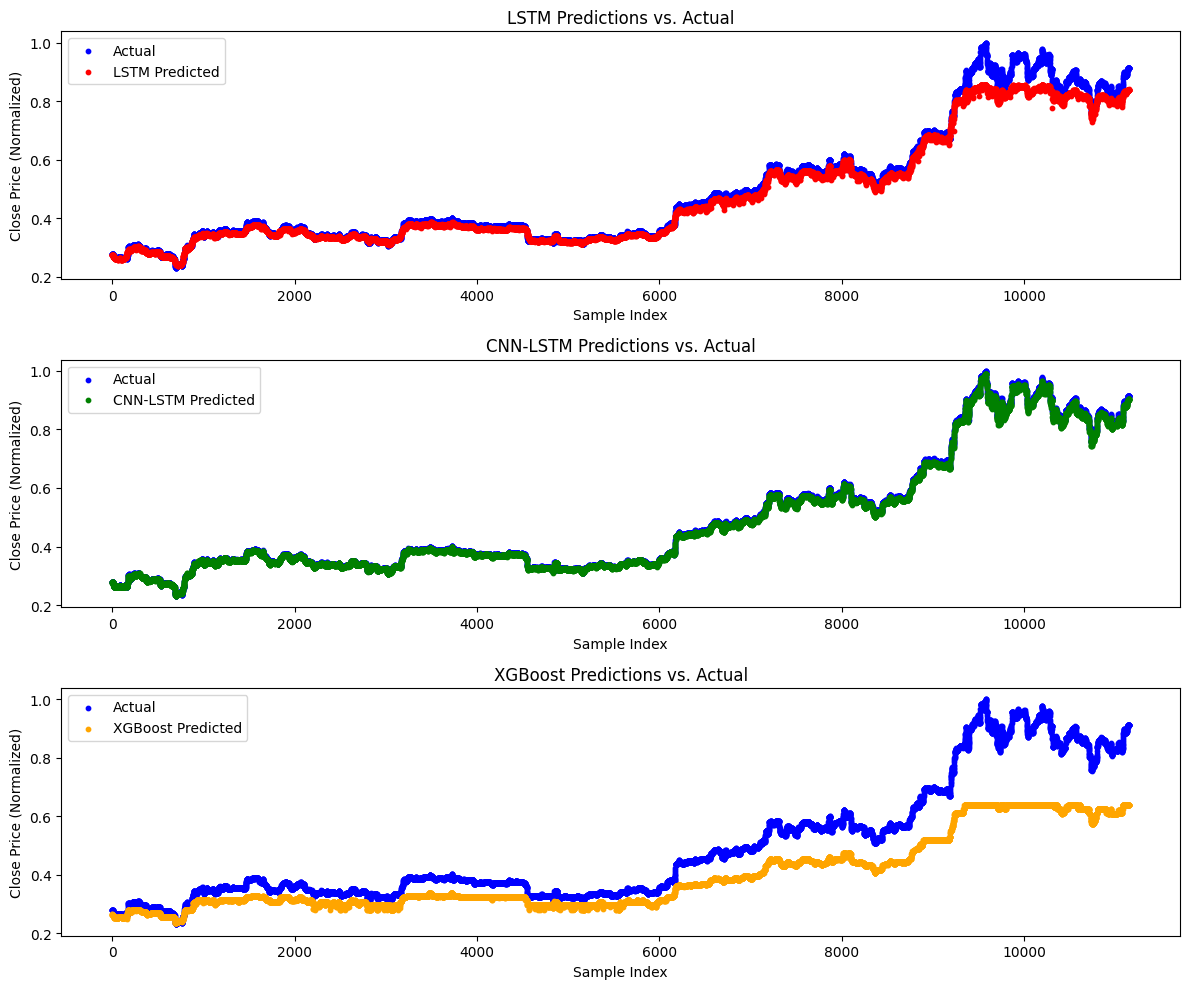

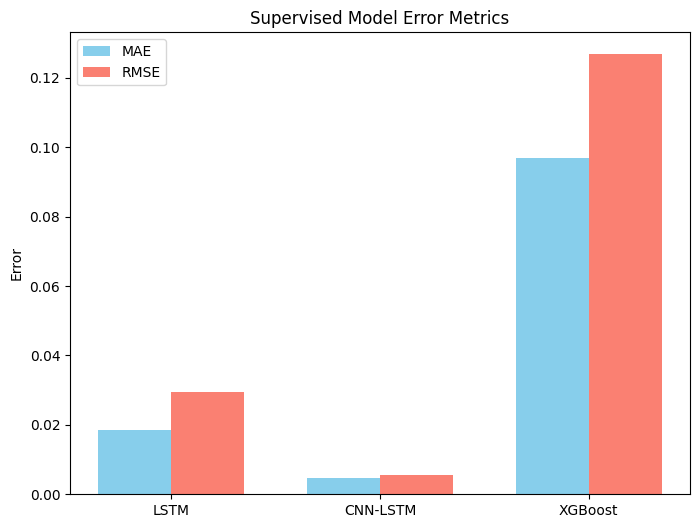

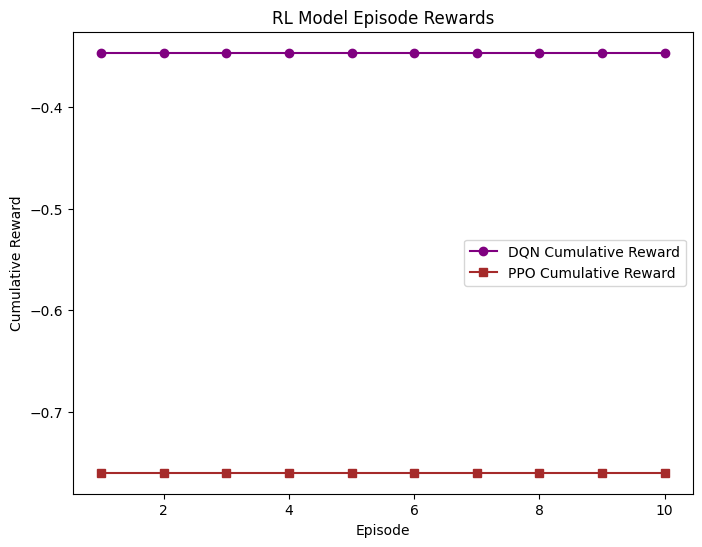

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ================================
# Supervised Models: Prediction Plots
# ================================

# Get predictions from each model on the test set
y_pred_lstm = lstm_model.predict(X_test)          # shape: (num_samples, 1)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)    # shape: (num_samples, 1)
y_pred_xgboost = xgboost_model.predict(X_test.reshape(X_test.shape[0], -1))

# Flatten predictions and true values for plotting
y_true = y_test.flatten()
y_lstm = y_pred_lstm.flatten()
y_cnn_lstm = y_pred_cnn_lstm.flatten()
y_xgb = y_pred_xgboost.flatten()

plt.figure(figsize=(12, 10))

# LSTM Predictions vs Actual
plt.subplot(3, 1, 1)
plt.scatter(range(len(y_true)), y_true, label='Actual', color='blue', s=10)
plt.scatter(range(len(y_lstm)), y_lstm, label='LSTM Predicted', color='red', s=10)
plt.title('LSTM Predictions vs. Actual')
plt.xlabel('Sample Index')
plt.ylabel('Close Price (Normalized)')
plt.legend()

# CNN-LSTM Predictions vs Actual
plt.subplot(3, 1, 2)
plt.scatter(range(len(y_true)), y_true, label='Actual', color='blue', s=10)
plt.scatter(range(len(y_cnn_lstm)), y_cnn_lstm, label='CNN-LSTM Predicted', color='green', s=10)
plt.title('CNN-LSTM Predictions vs. Actual')
plt.xlabel('Sample Index')
plt.ylabel('Close Price (Normalized)')
plt.legend()

# XGBoost Predictions vs Actual
plt.subplot(3, 1, 3)
plt.scatter(range(len(y_true)), y_true, label='Actual', color='blue', s=10)
plt.scatter(range(len(y_xgb)), y_xgb, label='XGBoost Predicted', color='orange', s=10)
plt.title('XGBoost Predictions vs. Actual')
plt.xlabel('Sample Index')
plt.ylabel('Close Price (Normalized)')
plt.legend()

plt.tight_layout()
plt.show()

# ================================
# Supervised Models: Error Metrics Bar Chart
# ================================

# Assume you have computed evaluation metrics for each supervised model:
# For example, each is a dict like: {'MAE': value, 'RMSE': value}
# (lstm_eval, cnn_lstm_eval, xgboost_eval)

metrics = {
    'LSTM': lstm_eval,
    'CNN-LSTM': cnn_lstm_eval,
    'XGBoost': xgboost_eval
}

labels = list(metrics.keys())
mae_values = [metrics[m]['MAE'] for m in labels]
rmse_values = [metrics[m]['RMSE'] for m in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, mae_values, width, label='MAE', color='skyblue')
plt.bar(x + width/2, rmse_values, width, label='RMSE', color='salmon')
plt.xticks(x, labels)
plt.ylabel('Error')
plt.title('Supervised Model Error Metrics')
plt.legend()
plt.show()

# ================================
# RL Models: Episode Rewards Plot
# ================================

# Assume you have evaluated the RL models over several episodes:
# dqn_rewards and ppo_rewards are lists of cumulative rewards per episode.
episodes = np.arange(1, len(dqn_rewards) + 1)

plt.figure(figsize=(8, 6))
plt.plot(episodes, dqn_rewards, marker='o', label='DQN Cumulative Reward', color='purple')
plt.plot(episodes, ppo_rewards, marker='s', label='PPO Cumulative Reward', color='brown')
plt.title('RL Model Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()
